In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
labeled_dimreduce.py
--------------------
固定路径 + 可配置的降维可视化脚本（PCA / UMAP / t-SNE），并用“塑料名称”做点标注。

要点
- 仅做降维与可视化，不做聚类。
- 自动按列归一（robust/zscore/minmax/none），可选对非负列 log1p，行向量 L2。
- 标注优先使用 LABEL_TEXT_COL 指定的“塑料名称列”；若未指定，则在 CANDIDATE_NAME_COLS 中自动搜索。
- 若仍找不到用于标注的列且未设置 ID_COLS，则抛错（不再退回用序号）。

依赖
- pandas, numpy, scikit-learn, matplotlib
- 可选：umap-learn（未安装会自动跳过 UMAP）
"""

import os
import warnings
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.patheffects as mpatheffects

plt.switch_backend("Agg")
warnings.filterwarnings("ignore", category=UserWarning)

# =======================
# 配置区（直接修改这里）
# =======================
INPUT_CSV: str = "/Users/shulei/PycharmProjects/Plaszyme/test/outputs/t1.csv"  # 输入 CSV
OUTPUT_DIR: str = "outputs/dimreduce_labeled"                                   # 输出目录

# 元数据/特征列
ID_COLS: List[str] = []                 # 仅保留、不参与降维的列，如 ["PLZ_ID"]
FEATURE_COLS: List[str] = []            # 指定参与降维的特征列；留空则自动选择所有数值列（排除 ID_COLS）

# 降维方法
METHODS: List[str] = ["pca", "umap", "tsne"]   # 可选：["pca","umap","tsne"]
N_COMPONENTS: int = 2                           # 为 2 时会绘制 2D 图
RANDOM_STATE: int = 42

# 归一化（按列）
COL_SCALE: str = "robust"           # "robust" | "zscore" | "minmax" | "none"
LOG1P_NONNEG: bool = False          # 缩放前对全非负列 log1p
APPLY_ROW_L2: bool = False          # 缩放后对每个样本向量 L2 归一

# UMAP 参数
UMAP_N_NEIGHBORS: int = 15
UMAP_MIN_DIST: float = 0.1
UMAP_METRIC: str = "euclidean"

# t-SNE 参数（会基于样本量自动调整 perplexity）
TSNE_PERPLEXITY: float = 30.0
TSNE_LEARNING_RATE = "auto"

# —— 图上“塑料名称”标注 ——
# 明确指定名称列（强烈推荐）：如 "plastic" 或 "name"
LABEL_TEXT_COL: Optional[str] = "plastic"
# 若上面为空或该列不存在，将在以下候选里自动寻找（忽略大小写）：
CANDIDATE_NAME_COLS: List[str] = ["plastic", "plastic_name", "name", "polymer", "material"]

MAX_LABEL_LEN: int = 28             # 文本过长截断
LABEL_OFFSET: float = 0.012         # 文本相对偏移比例
DRAW_GUIDE_LINE: bool = True        # 画引线

FIGSIZE = (7.0, 5.8)
DPI = 180


# =======================
# 工具函数
# =======================
def ensure_outdir(path: str):
    os.makedirs(path, exist_ok=True)


def load_and_split(csv_path: str,
                   id_cols: List[str],
                   feature_cols: Optional[List[str]] = None
                   ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(csv_path)
    id_cols = [c for c in id_cols if c in df.columns]

    if feature_cols:
        feats = [c for c in feature_cols if c in df.columns]
        X = df[feats].select_dtypes(include=[np.number]).copy()
    else:
        feats = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_cols]
        X = df[feats].copy()

    if X.shape[1] == 0:
        raise ValueError("未找到可用的数值特征列，请在 FEATURE_COLS 中显式指定。")

    meta = df[id_cols].copy() if id_cols else pd.DataFrame(index=df.index)
    return df, meta, X


def preprocess_columns(X: pd.DataFrame,
                       col_scale: str = "robust",
                       log1p_nonneg: bool = False,
                       apply_row_l2: bool = False,
                       eps: float = 1e-12) -> pd.DataFrame:
    X_imp = pd.DataFrame(SimpleImputer(strategy="median").fit_transform(X),
                         columns=X.columns, index=X.index)

    if log1p_nonneg:
        nonneg_cols = [c for c in X_imp.columns if (X_imp[c] >= 0).all()]
        if nonneg_cols:
            X_imp[nonneg_cols] = np.log1p(X_imp[nonneg_cols])

    if col_scale == "robust":
        scaler = RobustScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_imp),
                                columns=X_imp.columns, index=X_imp.index)
    elif col_scale == "zscore":
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_imp),
                                columns=X_imp.columns, index=X_imp.index)
    elif col_scale == "minmax":
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_imp),
                                columns=X_imp.columns, index=X_imp.index)
    elif col_scale == "none":
        X_scaled = X_imp.copy()
    else:
        raise ValueError("COL_SCALE 仅支持 'robust' | 'zscore' | 'minmax' | 'none'")

    if apply_row_l2:
        arr = X_scaled.values
        norms = np.sqrt((arr ** 2).sum(axis=1, keepdims=True))
        norms = np.maximum(norms, eps)
        X_scaled = pd.DataFrame(arr / norms, columns=X_scaled.columns, index=X_scaled.index)

    return X_scaled


def pick_label_series(df: pd.DataFrame,
                      id_cols: List[str],
                      label_col: Optional[str],
                      candidates: List[str],
                      max_len: int) -> pd.Series:
    # 1) 明确指定
    if label_col and (label_col in df.columns):
        s = df[label_col].astype(str)
    else:
        # 2) 候选自动搜索（忽略大小写）
        lower_map = {c.lower(): c for c in df.columns}
        hit = None
        for k in candidates:
            if k.lower() in lower_map:
                hit = lower_map[k.lower()]
                break
        # 3) 再做一次宽松匹配（包含关键字）
        if not hit:
            for c in df.columns:
                lc = c.lower()
                if any(key in lc for key in ["plastic", "polymer", "material", "name"]):
                    hit = c
                    break

        if hit:
            s = df[hit].astype(str)
        elif id_cols:
            # 4) 回退到 ID_COLS 拼接（不使用序号）
            parts = [df[c].astype(str) for c in id_cols if c in df.columns]
            if parts:
                s = pd.Series(["|".join(vals) for vals in zip(*parts)], index=df.index)
            else:
                raise ValueError("未找到用于标注的列，请设置 LABEL_TEXT_COL 或在 CANDIDATE_NAME_COLS 中加入正确列名。")
        else:
            raise ValueError("未找到用于标注的列，请设置 LABEL_TEXT_COL 或在 CANDIDATE_NAME_COLS 中加入正确列名。")

    s = s.fillna("").apply(lambda t: (t if len(t) <= max_len else (t[:max_len - 1] + "…")))
    return s


def save_embedding_csv(meta: pd.DataFrame, emb: np.ndarray, method: str, outdir: str) -> pd.DataFrame:
    cols = [f"{method}_{i+1}" for i in range(emb.shape[1])]
    emb_df = pd.DataFrame(emb, columns=cols, index=meta.index)
    out = pd.concat([meta.reset_index(drop=True), emb_df.reset_index(drop=True)], axis=1)
    out_path = os.path.join(outdir, f"{method}_embedding.csv")
    out.to_csv(out_path, index=False)
    print(f"[SAVE] {out_path}")
    return emb_df


def scatter2d_labeled(emb: np.ndarray,
                      labels: pd.Series,
                      title: str,
                      xlabel: str,
                      ylabel: str,
                      out_png: str,
                      offset_ratio: float = 0.01,
                      draw_guide_line: bool = True):
    if emb.shape[1] != 2:
        return
    x = emb[:, 0]
    y = emb[:, 1]
    xr = (x.max() - x.min()) or 1.0
    yr = (y.max() - y.min()) or 1.0
    dx = xr * offset_ratio
    dy = yr * offset_ratio

    plt.figure(figsize=FIGSIZE, dpi=DPI)
    plt.scatter(x, y, s=20, alpha=0.9)

    # 白描边提升可读性
    text_effect = [mpatheffects.withStroke(linewidth=2.4, foreground="white", alpha=0.9)]
    # 扇形微偏移，减少重叠
    angles = np.linspace(0, 2 * np.pi, num=len(labels), endpoint=False)
    for i, txt in enumerate(labels.values):
        ox = dx * np.cos(angles[i])
        oy = dy * np.sin(angles[i])
        tx, ty = x[i] + ox, y[i] + oy
        plt.text(tx, ty, str(txt), fontsize=8, ha="left", va="bottom", path_effects=text_effect)
        if draw_guide_line:
            plt.plot([x[i], tx], [y[i], ty], linewidth=0.7, alpha=0.6)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()
    print(f"[PLOT] {out_png}")


# =======================
# 降维实现
# =======================
def run_pca(X: np.ndarray, n_components: int, random_state: int):
    model = PCA(n_components=n_components, random_state=random_state)
    emb = model.fit_transform(X)
    var = getattr(model, "explained_variance_ratio_", None)
    return emb, var


def run_umap(X: np.ndarray, n_components: int, random_state: int,
             n_neighbors: int, min_dist: float, metric: str):
    try:
        import umap
        UMAP = umap.UMAP
    except Exception:
        try:
            from umap.umap_ import UMAP
        except Exception:
            print("[WARN] 未安装 umap-learn，跳过 UMAP。 (pip install umap-learn)")
            return None
    model = UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )
    return model.fit_transform(X)


def run_tsne(X: np.ndarray, n_components: int, random_state: int,
             perplexity: float, learning_rate):
    n = X.shape[0]
    if n <= 3 * perplexity:
        new_perp = max(3.0, min(perplexity, max(2.0, (n - 1) / 3.2)))
        print(f"[INFO] 样本数较少（n={n}），t-SNE perplexity 自动调整为 {new_perp:.1f}")
        perplexity = new_perp
    try:
        model = TSNE(
            n_components=n_components,
            perplexity=perplexity,
            learning_rate=learning_rate,
            init="pca",
            random_state=random_state
        )
        return model.fit_transform(X)
    except TypeError:
        model = TSNE(
            n_components=n_components,
            perplexity=perplexity,
            learning_rate=200.0,
            init="pca",
            random_state=random_state
        )
        return model.fit_transform(X)


# =======================
# 主流程
# =======================
def main():
    ensure_outdir(OUTPUT_DIR)

    df, meta, X = load_and_split(INPUT_CSV, ID_COLS, FEATURE_COLS)
    Xn = preprocess_columns(X, COL_SCALE, LOG1P_NONNEG, APPLY_ROW_L2)

    labels = pick_label_series(
        df=df,
        id_cols=ID_COLS,
        label_col=LABEL_TEXT_COL,
        candidates=CANDIDATE_NAME_COLS,
        max_len=MAX_LABEL_LEN
    )

    print(f"[INFO] 样本数: {Xn.shape[0]} | 特征维度: {Xn.shape[1]} | 方法: {METHODS} | 列缩放: {COL_SCALE}")

    emb_parts: List[pd.DataFrame] = []

    # PCA
    if "pca" in METHODS:
        pca_emb, var = run_pca(Xn.values, N_COMPONENTS, RANDOM_STATE)
        pca_df = save_embedding_csv(meta, pca_emb, "pca", OUTPUT_DIR)
        emb_parts.append(pca_df.add_prefix("pca_"))
        if var is not None:
            var_df = pd.DataFrame({"PC": [f"PC{i+1}" for i in range(len(var))],
                                   "explained_variance_ratio": var})
            var_df.to_csv(os.path.join(OUTPUT_DIR, "pca_variance.csv"), index=False)
            print(f"[SAVE] {os.path.join(OUTPUT_DIR, 'pca_variance.csv')}")
        if N_COMPONENTS == 2:
            scatter2d_labeled(pca_emb, labels, "PCA (2D)", "PC1", "PC2",
                              os.path.join(OUTPUT_DIR, "pca_2d_labeled.png"),
                              offset_ratio=LABEL_OFFSET, draw_guide_line=DRAW_GUIDE_LINE)

    # UMAP
    if "umap" in METHODS:
        umap_emb = run_umap(Xn.values, N_COMPONENTS, RANDOM_STATE,
                            UMAP_N_NEIGHBORS, UMAP_MIN_DIST, UMAP_METRIC)
        if umap_emb is not None:
            umap_df = save_embedding_csv(meta, umap_emb, "umap", OUTPUT_DIR)
            emb_parts.append(umap_df.add_prefix("umap_"))
            if N_COMPONENTS == 2:
                scatter2d_labeled(umap_emb, labels, "UMAP (2D)", "UMAP-1", "UMAP-2",
                                  os.path.join(OUTPUT_DIR, "umap_2d_labeled.png"),
                                  offset_ratio=LABEL_OFFSET, draw_guide_line=DRAW_GUIDE_LINE)

    # t-SNE
    if "tsne" in METHODS:
        tsne_emb = run_tsne(Xn.values, N_COMPONENTS, RANDOM_STATE,
                            TSNE_PERPLEXITY, TSNE_LEARNING_RATE)
        tsne_df = save_embedding_csv(meta, tsne_emb, "tsne", OUTPUT_DIR)
        emb_parts.append(tsne_df.add_prefix("tsne_"))
        if N_COMPONENTS == 2:
            scatter2d_labeled(tsne_emb, labels, "t-SNE (2D)", "tSNE-1", "tSNE-2",
                              os.path.join(OUTPUT_DIR, "tsne_2d_labeled.png"),
                              offset_ratio=LABEL_OFFSET, draw_guide_line=DRAW_GUIDE_LINE)

    # 合并嵌入
    if emb_parts:
        merged = pd.concat([meta.reset_index(drop=True)] + emb_parts, axis=1)
        merged.to_csv(os.path.join(OUTPUT_DIR, "all_embeddings_merged.csv"), index=False)
        print(f"[SAVE] {os.path.join(OUTPUT_DIR, 'all_embeddings_merged.csv')}")

    print("[DONE] 降维 + 塑料名称标注 完成。输出位于：", os.path.abspath(OUTPUT_DIR))


if __name__ == "__main__":
    main()

[INFO] 样本数: 17 | 特征维度: 27 | 方法: ['pca', 'umap', 'tsne'] | 列缩放: robust
[SAVE] outputs/dimreduce_labeled/pca_embedding.csv
[SAVE] outputs/dimreduce_labeled/pca_variance.csv
[PLOT] outputs/dimreduce_labeled/pca_2d_labeled.png


/opt/anaconda3/envs/Plaszyme/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[SAVE] outputs/dimreduce_labeled/umap_embedding.csv
[PLOT] outputs/dimreduce_labeled/umap_2d_labeled.png
[INFO] 样本数较少（n=17），t-SNE perplexity 自动调整为 5.0
[SAVE] outputs/dimreduce_labeled/tsne_embedding.csv
[PLOT] outputs/dimreduce_labeled/tsne_2d_labeled.png
[SAVE] outputs/dimreduce_labeled/all_embeddings_merged.csv
[DONE] 降维 + 塑料名称标注 完成。输出位于： /Users/shulei/PycharmProjects/Plaszyme/notebook/outputs/dimreduce_labeled


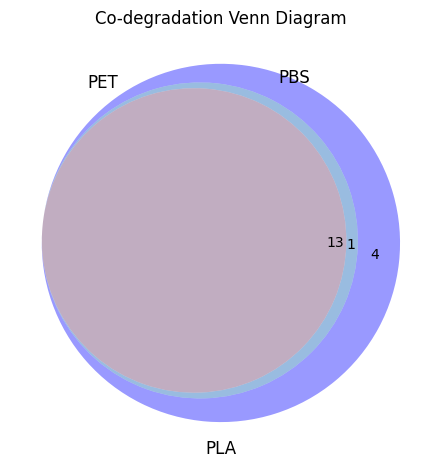

In [2]:
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# 加载共降解矩阵
co_matrix = pd.read_csv("/Users/shulei/PycharmProjects/Plaszyme/test/outputs/plastic_co_matrix.csv", index_col=0)

# 选定三个塑料
plastics = ["PET", "PBS", "PLA",]
threshold = 0.01  # 共降解判定阈值

# 构造集合
sets = {
    name: set(co_matrix.columns[(co_matrix.loc[name] >= threshold)])
    for name in plastics
}

# 画维恩图
venn3([sets[plastics[0]], sets[plastics[1]], sets[plastics[2]]], set_labels=plastics)
plt.title("Co-degradation Venn Diagram")
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/Plaszyme/lib/python3.12/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/opt/anaconda3/envs/Plaszyme/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fil

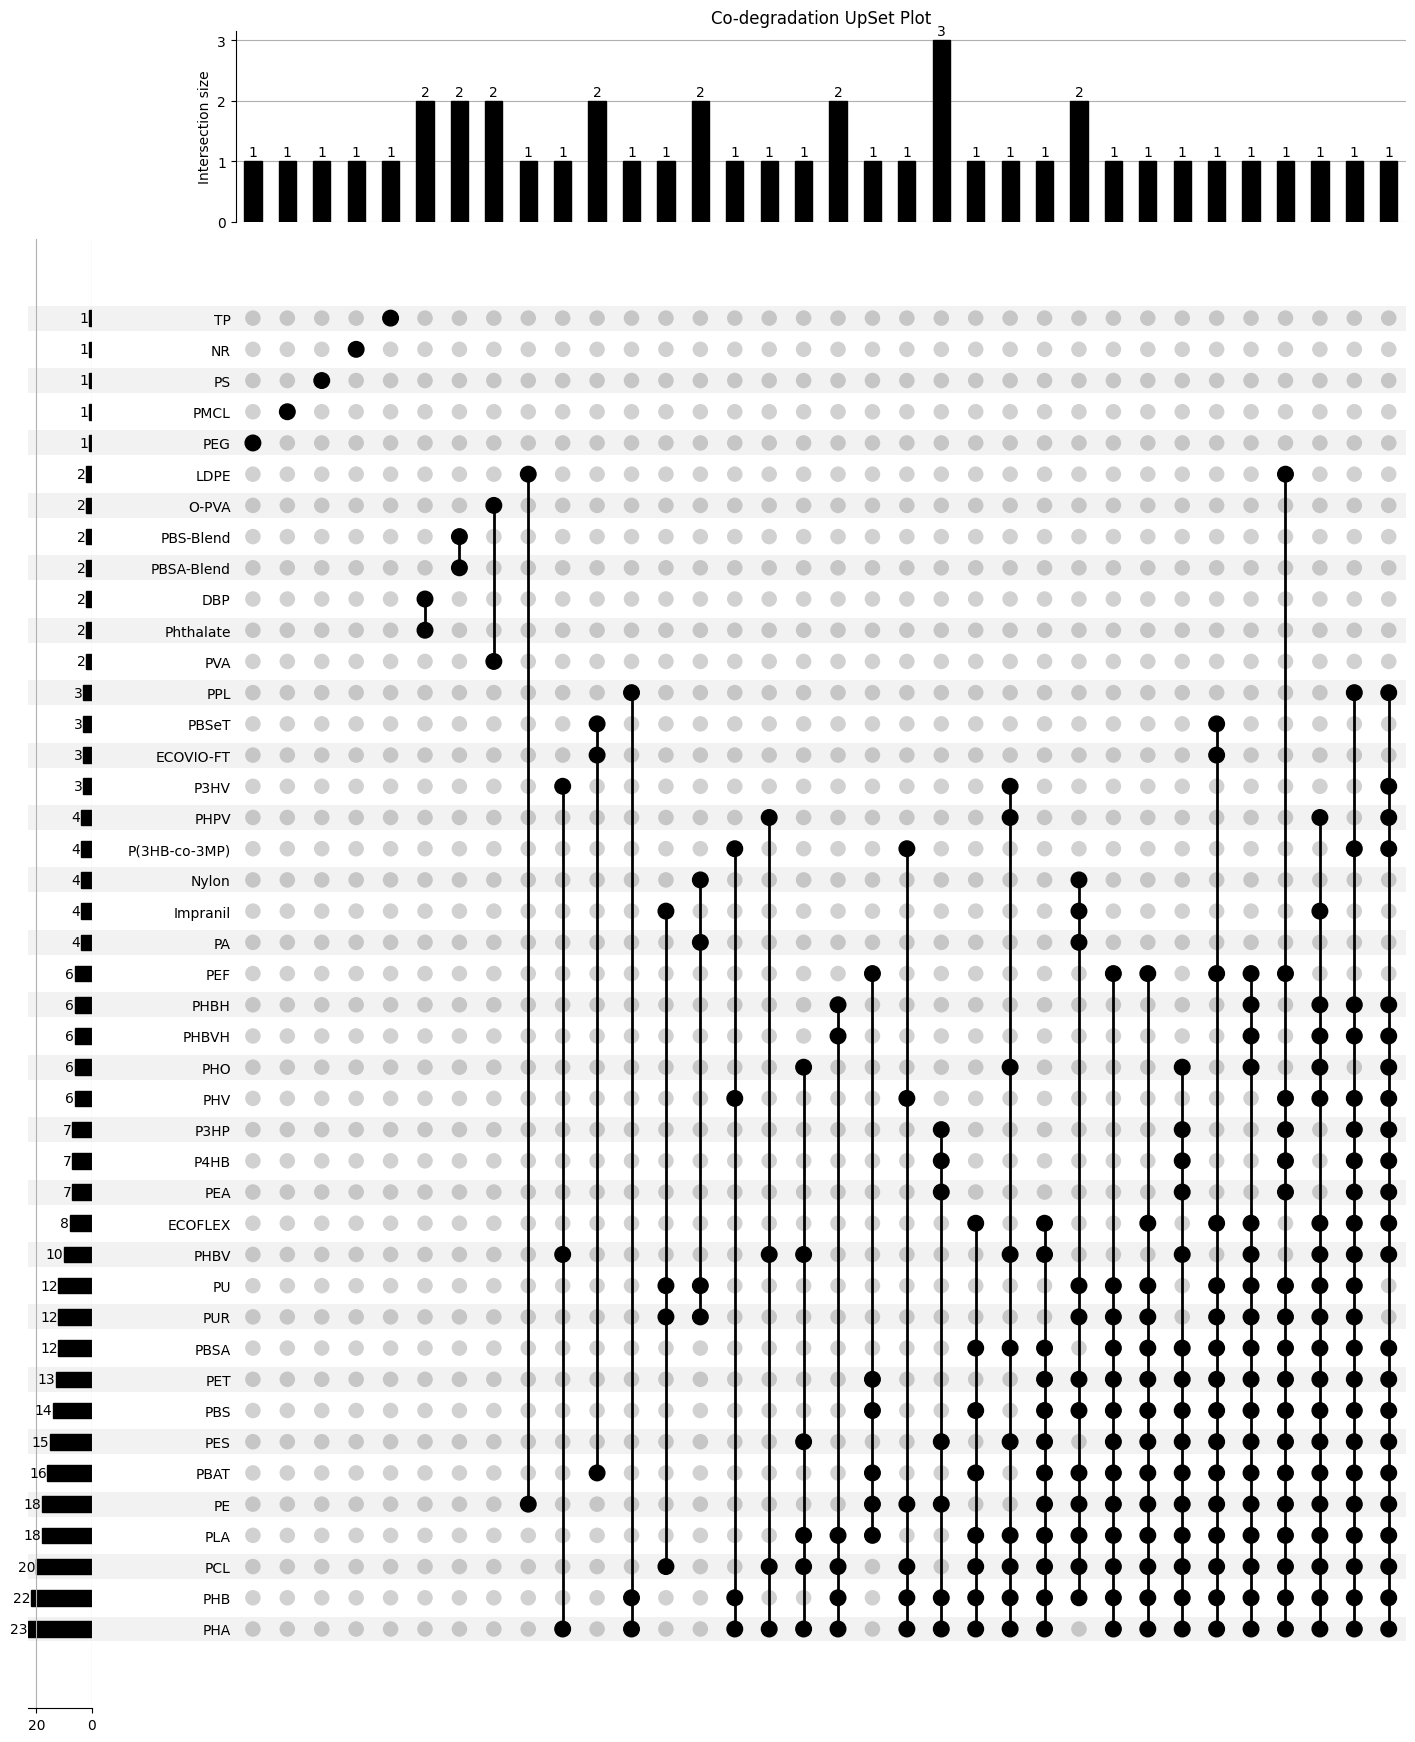

In [6]:
from upsetplot import from_contents, plot
import matplotlib.pyplot as plt

plastics = list(co_matrix.index)

threshold = 0.01  # 原设定保留
sets = {
    name: set(co_matrix.columns[(co_matrix.loc[name] >= threshold)])
    for name in plastics
}

# 转为 UpSet 格式并绘图
data = from_contents(sets)
plot(data, show_counts='%d')
plt.title("Co-degradation UpSet Plot")
plt.show()